In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [7]:
# # import tensorflow as tf
# # import seaborn as sns
# # tf.test.gpu_device_name()
# import torch
# import random
# seed = 12
# # torch.manual_seed(seed)
# # torch.cuda.manual_seed(seed)
# # torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
# random.seed(seed)
# # torch.backends.cudnn.benchmark = False
# # torch.use_deterministic_algorithms(True)

### Generate Embedding

In [8]:
import ast
class allaction():
    
    def __init__(self, file):
        self.df = pd.read_csv(file) 
        # self.df = self.sdf.sample(frac=1, random_state=42).reset_index().drop("index", axis=1)
        self.orderId, self.taskId, self.taskTicks, self.workerId, self.workerTicks = [], [], [], [], []
        self.ResponseId, self.Round, self.Tick = [], [], []
    #taskId: 0~idle, 1~chop, 2~cook, 3~plate
    #workerId: 0~chef, 1~sou-chef, 2~server
    #           0~sou-chef, 1~server, CHANGE!!! 0~idle, 1~chef, 2~sou-chef, 3~server
    
    def parse(self):
        # all id + 1, leaving 0 to be idle
        action = self.df
        for i in tqdm(np.arange(action.shape[0])):
            row = action.iloc[i,:]
            for act in ["action1", "action2", "action3"]:
                # when there is no action in this act
                if type(row[act]) != str:
                    self.orderId.append(0)
                    self.taskId.append(0)
                    self.taskTicks.append(0)
                    self.workerId.append(0)
                    self.workerTicks.append(0)
                else:
                    a = ast.literal_eval(row[act])
                    self.orderId.append(a["order_id"] + 1)
                    self.taskId.append(a["task_id"] + 1)
                    self.taskTicks.append(a["task_ticks"])
                    self.workerId.append(a["worker_id"] + 1)
                    self.workerTicks.append(a["worker_ticks"])

                self.ResponseId.append(row["ResponseId"])
                self.Round.append(row["round"])
                self.Tick.append(row["tick"])
                
    def get(self):
        self.parse()
        d = {
            "ResponseId": self.ResponseId,
            "round": self.Round,
            "tick": self.Tick,
            "orderId": self.orderId, 
            "taskId": self.taskId, 
            "taskTicks": self.taskTicks, 
            "workerId": self.workerId, 
            "workerTicks": self.workerTicks
        }
        return pd.DataFrame(d)

In [9]:
# pwd

In [10]:
file =  "../data/phase2/phase2_action.csv"
action = allaction(file).get()
action = action[action["round"] <= 2]
action = action.drop("workerTicks", axis=1)
label=pd.read_csv( "../data/phase2/phase2_control_label.csv")
action = action.merge(label,how = "inner",
            left_on="ResponseId", right_on="ResponseId")
y = action.groupby("ResponseId").agg(np.mean)["best_tip"].astype(int)            
action            

100%|██████████| 195642/195642 [00:38<00:00, 5124.35it/s]


,ResponseId,round,tick,orderId,taskId,taskTicks,workerId,best_tip
0,R_0DNcJqALC3UG9Db,1,1,1,1,2,1,2
1,R_0DNcJqALC3UG9Db,1,1,2,1,2,2,2
2,R_0DNcJqALC3UG9Db,1,1,3,1,2,3,2
3,R_0DNcJqALC3UG9Db,1,2,0,0,0,0,2
4,R_0DNcJqALC3UG9Db,1,2,0,0,0,0,2
...,...,...,...,...,...,...,...,...
32473,R_z6DSJfELElPHABP,2,19,0,0,0,0,3
32474,R_z6DSJfELElPHABP,2,19,0,0,0,0,3
32475,R_z6DSJfELElPHABP,2,20,4,3,2,3,3
32476,R_z6DSJfELElPHABP,2,20,0,0,0,0,3


In [11]:
t1 = action.drop("orderId", axis=1)
t2 = t1.merge(pd.get_dummies(t1["taskId"]), left_index=True, right_index=True).drop("taskId", axis=1).rename(
    columns={0:"idle", 1:"chop", 2:"cook", 3:"plate"})
df = t2.merge(pd.get_dummies(t2["workerId"]), left_index=True, right_index=True).drop("workerId", axis=1).rename(
    columns={0:"idle", 1:"chef", 2:"sou-chef", 3:"server"})
# df = df.drop("taskTicks", axis=1).groupby(["ResponseId", "round", "tick"]).sum().iloc[:,1:]
df

,ResponseId,round,tick,taskTicks,best_tip,idle,chop,cook,plate,idle,chef,sou-chef,server
0,R_0DNcJqALC3UG9Db,1,1,2,2,0,1,0,0,0,1,0,0
1,R_0DNcJqALC3UG9Db,1,1,2,2,0,1,0,0,0,0,1,0
2,R_0DNcJqALC3UG9Db,1,1,2,2,0,1,0,0,0,0,0,1
3,R_0DNcJqALC3UG9Db,1,2,0,2,1,0,0,0,1,0,0,0
4,R_0DNcJqALC3UG9Db,1,2,0,2,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32473,R_z6DSJfELElPHABP,2,19,0,3,1,0,0,0,1,0,0,0
32474,R_z6DSJfELElPHABP,2,19,0,3,1,0,0,0,1,0,0,0
32475,R_z6DSJfELElPHABP,2,20,2,3,0,0,0,1,0,0,0,1
32476,R_z6DSJfELElPHABP,2,20,0,3,1,0,0,0,1,0,0,0


In [12]:
a = df.drop("taskTicks", axis=1)
X = a.groupby(["ResponseId", "round", "tick", "best_tip"]).agg(lambda x: x.iloc[0]).merge(
    a.groupby(["ResponseId", "round", "tick", "best_tip"]).agg(lambda x: x.iloc[1]).merge(
        a.groupby(["ResponseId", "round", "tick", "best_tip"]).agg(lambda x: x.iloc[2])
    , left_index=True, right_index=True), left_index=True, right_index=True)
X    

idle  chop  cook  plate  idle  chef  \
ResponseId        round tick best_tip                                        
R_0DNcJqALC3UG9Db 1     1    2            0     1     0      0     0     1   
                        2    2            1     0     0      0     1     0   
                        3    2            0     0     1      0     0     1   
                        4    2            0     0     1      0     0     0   
                        5    2            0     0     1      0     0     0   
...                                     ...   ...   ...    ...   ...   ...   
R_z6DSJfELElPHABP 2     16   3            1     0     0      0     1     0   
                        17   3            1     0     0      0     1     0   
                        18   3            1     0     0      0     1     0   
                        19   3            1     0     0      0     1     0   
                        20   3            0     0     0      1     0     0   

                                       sou-chef  server  idle_x  chop_x  ...  \
ResponseId        round tick best_tip                                    ...   
R_0DNcJqALC3UG9Db 1     1    2                0       0       0       1  ...   
                        2    2                0       0       1       0  ...   
                        3    2                0       0       1       0  ...   
                        4    2                1       0       1       0  ...   
                        5    2                0       1       1       0  ...   
...                                         ...     ...     ...     ...  ...   
R_z6DSJfELElPHABP 2     16   3                0       0       1       0  ...   
                        17   3                0       0       1       0  ...   
                        18   3                0       0       1       0  ...   
                        19   3                0       0       1       0  ...   
                        20   3                0       1       1       0  ...   

                                       sou-chef_x  server_x  idle_y  chop_y  \
ResponseId        round tick best_tip                                         
R_0DNcJqALC3UG9Db 1     1    2                  1         0       0       1   
                        2    2                  0         0       1       0   
                        3    2                  0         0       1       0   
                        4    2                  0         0       1       0   
                        5    2                  0         0       1       0   
...                                           ...       ...     ...     ...   
R_z6DSJfELElPHABP 2     16   3                  0         0       1       0   
                        17   3                  0         0       1       0   
                        18   3                  0         0       1       0   
                        19   3                  0         0       1       0   
                        20   3                  0         0       1       0   

                                       cook_y  plate_y  idle_y  chef_y  \
ResponseId        round tick best_tip                                    
R_0DNcJqALC3UG9Db 1     1    2              0        0       0       0   
                        2    2              0        0       1       0   
                        3    2              0        0       1       0   
                        4    2              0        0       1       0   
                        5    2              0        0       1       0   
...                                       ...      ...     ...     ...   
R_z6DSJfELElPHABP 2     16   3              0        0       1       0   
                        17   3              0        0       1       0   
                        18   3              0        0       1       0   
                        19   3              0        0       1       0   
                        20   3              0        0       1     

In [13]:
# chop0, chef0, server3
embeddings = []
for i in tqdm(np.arange(X.shape[0])):
    embedding = [0,0,0,0,0,0,0,0,0]
    thisline = X.iloc[i,:]
    
    if thisline["chop"] and thisline["chef"]:
        embedding[0] = 1
    elif thisline["chop"] and thisline["sou-chef"]:
        embedding[1] = 1
    elif thisline["chop"] and thisline["server"]:
        embedding[2] = 1 
    elif thisline["cook"] and thisline["chef"]:
        embedding[3] = 1 
    elif thisline["cook"] and thisline["sou-chef"]:
        embedding[4] = 1
    elif thisline["cook"] and thisline["server"]:
        embedding[5] = 1 
    elif thisline["plate"] and thisline["chef"]:
        embedding[6] = 1 
    elif thisline["plate"] and thisline["sou-chef"]:
        embedding[7] = 1
    elif thisline["plate"] and thisline["server"]:
        embedding[8] = 1 
        
    if thisline["chop_x"] and thisline["chef_x"]:
        embedding[0] = 1
    elif thisline["chop_x"] and thisline["sou-chef_x"]:
        embedding[1] = 1
    elif thisline["chop_x"] and thisline["server_x"]:
        embedding[2] = 1 
    elif thisline["cook_x"] and thisline["chef_x"]:
        embedding[3] = 1 
    elif thisline["cook_x"] and thisline["sou-chef_x"]:
        embedding[4] = 1
    elif thisline["cook_x"] and thisline["server_x"]:
        embedding[5] = 1 
    elif thisline["plate_x"] and thisline["chef_x"]:
        embedding[6] = 1 
    elif thisline["plate_x"] and thisline["sou-chef_x"]:
        embedding[7] = 1
    elif thisline["plate_x"] and thisline["server_x"]:
        embedding[8] = 1         
        
    if thisline["chop_y"] and thisline["chef_y"]:
        embedding[0] = 1
    elif thisline["chop_y"] and thisline["sou-chef_y"]:
        embedding[1] = 1
    elif thisline["chop_y"] and thisline["server_y"]:
        embedding[2] = 1 
    elif thisline["cook_y"] and thisline["chef_y"]:
        embedding[3] = 1 
    elif thisline["cook_y"] and thisline["sou-chef_y"]:
        embedding[4] = 1
    elif thisline["cook_y"] and thisline["server_y"]:
        embedding[5] = 1 
    elif thisline["plate_y"] and thisline["chef_y"]:
        embedding[6] = 1 
    elif thisline["plate_y"] and thisline["sou-chef_y"]:
        embedding[7] = 1
    elif thisline["plate_y"] and thisline["server_y"]:
        embedding[8] = 1  
    
    embeddings.append(embedding)
   

100%|██████████| 10826/10826 [00:05<00:00, 1913.94it/s]


In [14]:
kkk = df.drop("taskTicks", axis=1).groupby(["ResponseId", "round", "tick", "best_tip"]).sum().iloc[:,1:]
kkk["index"] = np.arange(kkk.shape[0])
X = kkk.merge(pd.DataFrame(np.array(embeddings)),how="left", left_on="index", right_index=True).drop(
    "chop", axis=1).drop("cook", axis=1).drop("plate", axis=1).drop("idle", axis=1).drop(
    "chef", axis=1).drop("sou-chef", axis=1).drop("server", axis=1).drop("index", axis=1)
X = X.reset_index()
X

,ResponseId,round,tick,best_tip,0,1,2,3,4,5,6,7,8
0,R_0DNcJqALC3UG9Db,1,1,2,1,1,1,0,0,0,0,0,0
1,R_0DNcJqALC3UG9Db,1,2,2,0,0,0,0,0,0,0,0,0
2,R_0DNcJqALC3UG9Db,1,3,2,0,0,0,1,0,0,0,0,0
3,R_0DNcJqALC3UG9Db,1,4,2,0,0,0,0,1,0,0,0,0
4,R_0DNcJqALC3UG9Db,1,5,2,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10821,R_z6DSJfELElPHABP,2,16,3,0,0,0,0,0,0,0,0,0
10822,R_z6DSJfELElPHABP,2,17,3,0,0,0,0,0,0,0,0,0
10823,R_z6DSJfELElPHABP,2,18,3,0,0,0,0,0,0,0,0,0
10824,R_z6DSJfELElPHABP,2,19,3,0,0,0,0,0,0,0,0,0


In [15]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

(array([80., 59., 55., 17., 11.,  6.,  5.,  3.,  2.,  3.]),
 array([38. , 41.4, 44.8, 48.2, 51.6, 55. , 58.4, 61.8, 65.2, 68.6, 72. ]),
 <BarContainer object of 10 artists>)

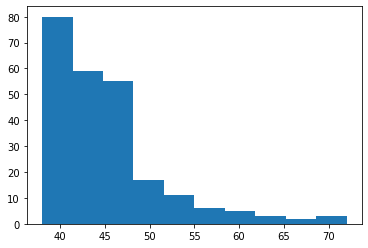

In [16]:
import matplotlib.pyplot as plt
plt.hist(X.groupby("ResponseId").count()["round"])

In [17]:
data = []
MAX_TIME_TICK = max(X.groupby("ResponseId").count()["round"])
# MAX_TIME_TICK = 75
for player in tqdm(set(X["ResponseId"])):
    batch = np.array(X[X["ResponseId"] == player].iloc[:MAX_TIME_TICK,4:]).tolist()
    padding = MAX_TIME_TICK - len(batch)
    if padding > 0  :
        for _ in np.arange(padding):
            batch.append([0,0,0,0,0,0,0,0,0])
    data.append(batch)
tensor = np.array(data)    

100%|██████████| 241/241 [00:00<00:00, 548.70it/s]


### One Hot Encoding

In [18]:
# np.save("onehot.npy", tensor)

In [19]:
# sum(X.groupby("ResponseId").count()["round"] <=50)

### AutoEncoder

In [20]:
# coding: utf-8
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

# Even if you don't use them, you still have to import
import random
import numpy as np


# Seed
seed = 12
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

import torch 
import torch.nn as nn
X_ac = tensor.reshape(-1,9)
y_ac = tensor.reshape(-1,9)
U = []
for x in X_ac.tolist():
    if x not in U:
        U.append(x)
input_train, output_train = torch.tensor(U[:30], dtype=torch.float), torch.tensor(U[:30], dtype=torch.float)
input_val, output_val = torch.tensor(U[30:], dtype=torch.float), torch.tensor(U[30:], dtype=torch.float)

class autoencoder(nn.Module):
    def __init__(self, hidden_dim=9, s=0):
        super(autoencoder, self).__init__()
        # torch.manual_seed(s)
        self.encoder = nn.Sequential(
                            nn.Linear(9,12),
                            # nn.ReLU(),
                            nn.Linear(12,hidden_dim),
    
        )
        self.decoder = nn.Sequential(
                            nn.Linear(hidden_dim,12),
                            # nn.ReLU(),
                            nn.Linear(12, 9)
        )                
    def forward(self, x):
        hidden = self.encoder(x)
        out = self.decoder(hidden)
        return hidden, out

def eval(model, X_test, y_test, criterion = nn.MSELoss()):
    # torch.manual_seed(s)
    model.eval()
    with torch.no_grad():
        _, logit = model(X_test)
        loss = criterion(logit, y_test)
    print("loss of model: ", loss.item())  

def train(model, input_train, output_train, criterion = nn.MSELoss(), lr=0.00055):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    # torch.manual_seed(s)
    for epoch in np.arange(6e3):
        _, logit = model(input_train)
        loss = criterion(logit, output_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 1e3 == 0:
            print(f"loss of epoch {int(epoch)}: ", loss.item())
            eval(model, input_val, output_val)
            model.train()    
    print("model final loss:")        
    eval(model, input_val, output_val)  
    

model = autoencoder(9)
train(model, input_train, output_train)                       

loss of epoch 0:  0.24646995961666107
loss of model:  0.3007413148880005
loss of epoch 1000:  0.01175604946911335
loss of model:  0.039768971502780914
loss of epoch 2000:  0.0022157966159284115
loss of model:  0.010339416563510895
loss of epoch 3000:  4.478207626772146e-14
loss of model:  2.0859883102537086e-13
loss of epoch 4000:  1.2488193835427045e-14
loss of model:  6.388973687121782e-14
loss of epoch 5000:  4.377639066131464e-15
loss of model:  1.3663979751268526e-14
model final loss:
loss of model:  6.625220239363542e-15


In [21]:
tensor.shape

(241, 72, 9)

In [22]:
# error of compared to original embedding
((model(torch.tensor(X_ac, dtype=torch.float))[1] - torch.tensor(X_ac, dtype=torch.float)).sum(dim=1)**2).mean()

tensor(3.3734e-14, grad_fn=<MeanBackward0>)

In [23]:
tensor = model(torch.tensor(X_ac, dtype=torch.float))[0].reshape(241, 72, 9).detach().numpy()
tensor.shape 

(241, 72, 9)

In [24]:
tensor[0][0]

array([-0.26488218,  1.3466563 ,  0.40520802, -0.33474305,  0.98711413,
        1.182436  , -0.13877654, -0.00522178,  0.02943555], dtype=float32)

### Embedding and Lable

In [25]:
np.save("embedding_new.npy", tensor)

In [26]:
y.to_csv("label.csv")

In [27]:
np.load("embedding.npy")[0][0]

array([-0.32437998,  0.66100293,  0.14051628, -0.6917044 ,  0.9037944 ,
        1.5462208 , -0.8288189 , -0.18543722,  0.31393987], dtype=float32)

In [28]:
# torch.save(model.state_dict(), "autoencoder.pth")

In [51]:
model1 = autoencoder(9)
checkpoint = torch.load("autoencoder.pth")
model1.load_state_dict(checkpoint)

<All keys matched successfully>

In [52]:
model1(torch.tensor(X_ac, dtype=torch.float))[0].reshape(241, 72, 9).detach().numpy() == np.load("embedding_new.npy")

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [45]:
np.load("embedding_new.npy")[0][0]

array([-0.26488218,  1.3466563 ,  0.40520802, -0.33474305,  0.98711413,
        1.182436  , -0.13877654, -0.00522178,  0.02943555], dtype=float32)